In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


# Exercice 6

## Présentation du Dataset

Le dataset "Red Wine Quality" contient des informations sur différentes caractéristiques chimiques des vins rouges provenant du Portugal. Chaque observation représente un échantillon de vin rouge et inclut plusieurs mesures propriétés chimiques ainsi qu'une évaluation de la qualité du vin. Le but est d'explorer comment ces propriétés chimiques affectent la qualité globale du vin. (dataset sur kaggle https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)

## Problème à Résoudre

Le problème que nous allons essayer de résoudre est la prédiction de la qualité du vin (notre variable cible) en fonction de ses propriétés chimiques (nos features). C'est un problème de classification multiclasse, car la qualité est notée de 0 à 10. Cependant, on va ici le transformer en un problème de classification binaire en définissant un seuil de qualité (on considère les vins avec une note ≥ 7 comme bons et les autres comme mauvais).

Résoudre ce problème pourrait avoir une valeur pour l'industrie du vin. Les vignerons pourraient utiliser ce modèle pour :

1 - Prédire la qualité potentielle d'un vin avant sa production finale.

2 - Identifier les caractéristiques chimiques les plus importantes pour la qualité du vin.

3 - Optimiser leurs processus de production pour améliorer la qualité de leurs vins.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# Importation et exploration des données

### On essaye ici de bien comprendre la structure des données et le contenu du dataset

In [19]:
df = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

print(df.head())
print(df.info())
print(df.describe())

print(df.isnull().sum())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

# Prétraitement des données

### On regarde d'abord la distribution des notes de qualité.
### Ensuite on transforme le problème en classification binaire (bonne qualité si quality ≥ 7, mauvaise sinon).
### Enfin, on divise les données en ensembles d'entraînement (80%) et de test (20%) et on les normalise ensuite pour que tout soit à la même échelle.

In [20]:
# Vérification de la distribution des classes
print(df['quality'].value_counts().sort_index())

# Transformation en problème de classification binaire
df['quality_binary'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Séparation des features et de la variable cible
X = df.drop(['quality', 'quality_binary'], axis=1)
y = df['quality_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


# Visualisation des données


### Cette étape nous aide à comprendre visuellement les relations entre les variables.

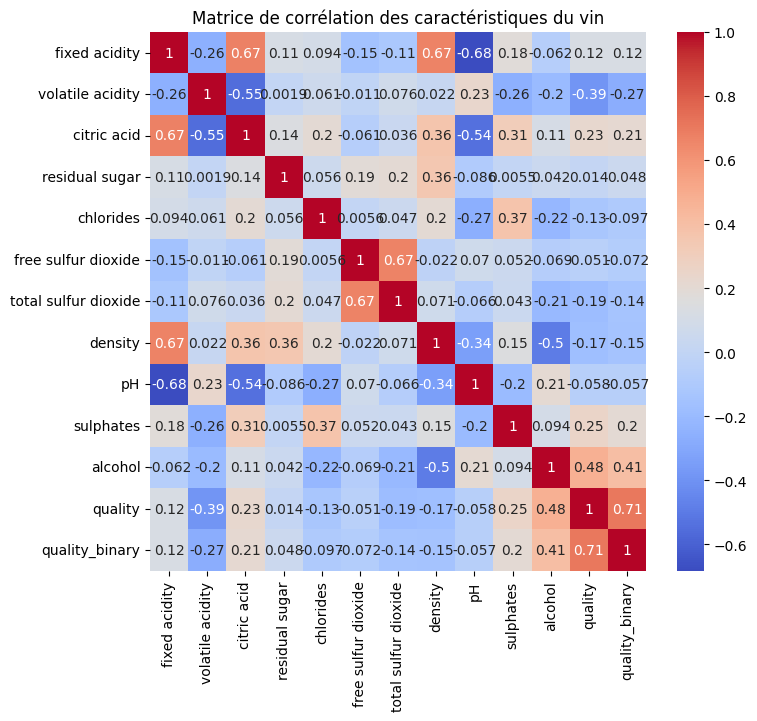

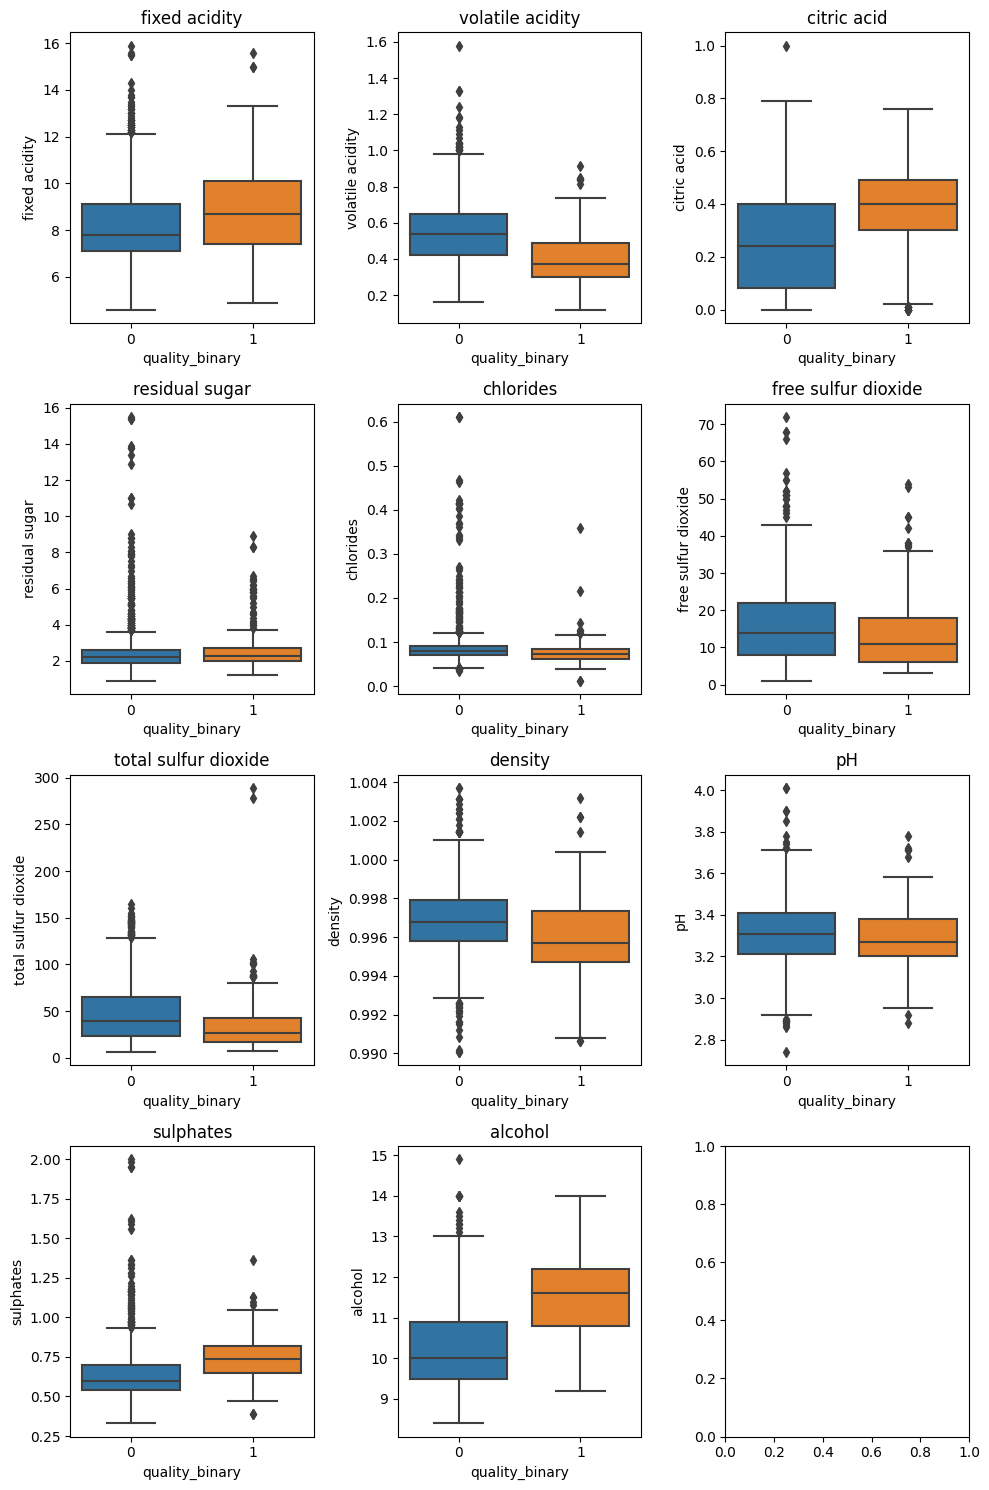

In [29]:
# Matrice de corrélation
plt.figure(figsize=(8, 7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation des caractéristiques du vin')
plt.show()

fig, axes = plt.subplots(4, 3, figsize=(10, 15))
axes = axes.ravel()

for i, column in enumerate(X.columns):
    sns.boxplot(x='quality_binary', y=column, data=df, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

### La matrice de corrélation montre les relations linéaires entre toutes les paires de variables.
### Les box plots comparent la distribution de chaque caractéristique entre les vins de bonne et mauvaise qualité.

# Sélection et préparation des features

### On utilise SelectKBest pour choisir les 5 meilleures features et on les affiche ensuite pour voir lesquelles sont retenues

In [24]:
selector = SelectKBest(f_classif, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()].tolist()
print("Features sélectionnées:", selected_features)

Features sélectionnées: ['volatile acidity', 'citric acid', 'total sulfur dioxide', 'sulphates', 'alcohol']


# Choix et entraînement des modèles
### Nous choisissons et entraînons deux modèles différents (Random Forest et SVM (avec SVC ici)) pour comparer leurs performances.

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_selected, y_train)

SVC(random_state=42)

# Évaluation des modèles

### Nous utilisons la cross-validation pour évaluer la stabilité du modèle.
### Nous générons un rapport de classification qui inclut la précision, le rappel et le f1-score.
### Nous créons une matrice de confusion pour visualiser les résultats.

Évaluation du Random Forest:

Scores de cross-validation: [0.875      0.9296875  0.87109375 0.9296875  0.91764706]
Score moyen de cross-validation: 0.905 (+/- 0.052)

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       273
           1       0.66      0.53      0.59        47

    accuracy                           0.89       320
   macro avg       0.79      0.74      0.76       320
weighted avg       0.88      0.89      0.89       320



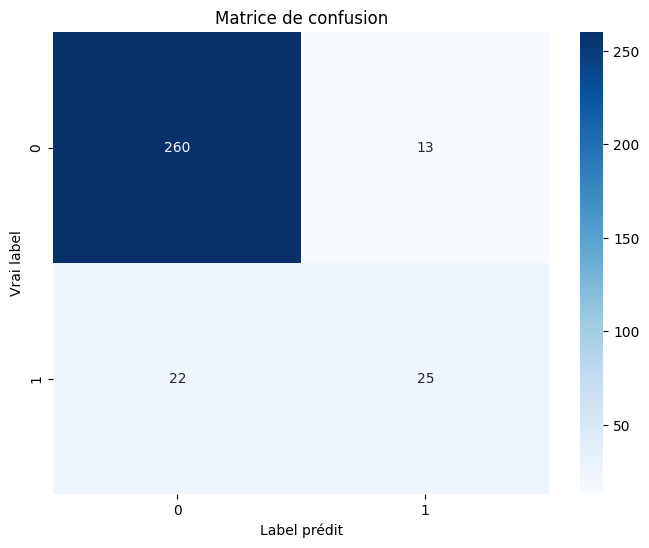

Évaluation du SVM:

Scores de cross-validation: [0.8828125  0.890625   0.87109375 0.8984375  0.90196078]
Score moyen de cross-validation: 0.889 (+/- 0.022)

Rapport de classification:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       273
           1       0.71      0.21      0.33        47

    accuracy                           0.87       320
   macro avg       0.80      0.60      0.63       320
weighted avg       0.85      0.87      0.84       320



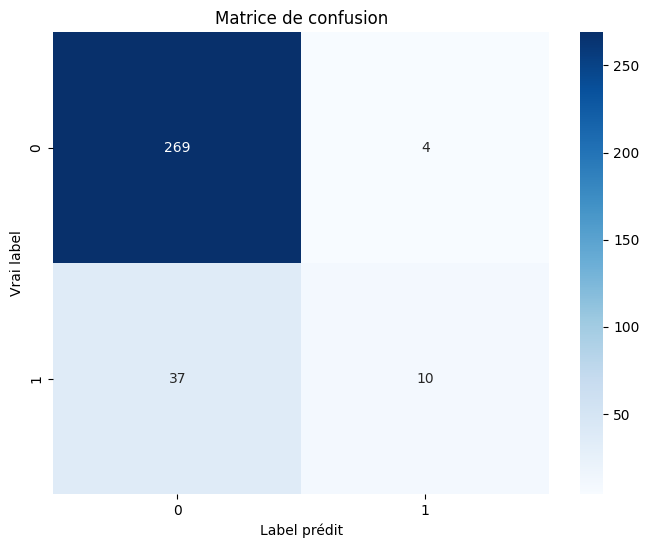

In [26]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Scores de cross-validation: {cv_scores}")
    print(f"Score moyen de cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    y_pred = model.predict(X_test)
    
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion')
    plt.ylabel('Vrai label')
    plt.xlabel('Label prédit')
    plt.show()

print("Évaluation du Random Forest:\n")
evaluate_model(rf_model, X_train_selected, X_test_selected, y_train, y_test)

print("Évaluation du SVM:\n")
evaluate_model(svm_model, X_train_selected, X_test_selected, y_train, y_test)

### On remarque ici que le Random Forest semble être le meilleur modèle. Il offre un meilleur équilibre entre la détection des vins de bonne et de mauvaise qualité. Le SVM, même si il a une précision similaire, il a tendance à sous-estimer la qualité des vins.

# 7. Interprétation des résultats
### Cette dernière étape nous aide à comprendre l'importance relative des différentes caractéristiques pour le meilleur model aka la random forest.

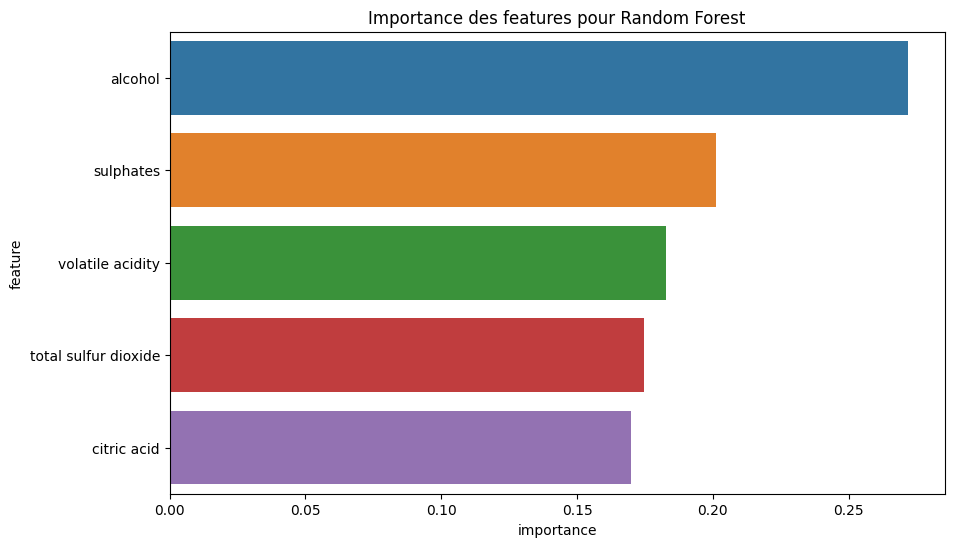

Importance des features:
                feature  importance
4               alcohol    0.271787
3             sulphates    0.201077
0      volatile acidity    0.182600
2  total sulfur dioxide    0.174701
1           citric acid    0.169835


In [27]:
feature_importance = pd.DataFrame({'feature': selected_features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importance des features pour Random Forest')
plt.show()

print("Importance des features:")
print(feature_importance)

# Conclusion
### Cette analyse nous fournit des informations sur les facteurs qui influencent la qualité du vin. Les résultats peuvent être utilisés par des vignerons pour:

### 1 - Concentrer leurs efforts sur les caractéristiques les plus importantes pour améliorer la qualité.

### 2 - Utiliser le modèle comme un outil de contrôle qualité préliminaire.

### 3 - Identifier les vins qui pourraient nécessiter une attention particulière


## Disclaimer

### Il faut quand même garder à l"esprit que la qualité du vin reste subjective et donc on ne peut pas se baser uniquement sur cette approche pour la définir, même si elle reste un bon premier pas pour visualiser les vins les plus prometteurs.